In [25]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import random
import os

In [26]:
def my_seed_everywhere(seed: int = 42):
    random.seed(seed) # random
    np.random.seed(seed) # np
    os.environ["PYTHONHASHSEED"] = str(seed) # os
    tf.random.set_seed(seed) # tensorflow

my_seed = 42
my_seed_everywhere(my_seed)

In [27]:
df = pd.read_csv('/content/sample_data/cabbage_final.csv', index_col=0)
df = df.dropna(axis=0)
df = df.reset_index(drop=True)
df['Date'] = pd.to_datetime(df['Date'])
df['DayOfWeek'] = df['Date'].dt.dayofweek

In [28]:
df = df.drop(['Temp'],axis=1)
df = df.drop(['Oil'],axis=1)
df = df.drop(['Sup'],axis=1)
df = df.drop(['Avg_Price'], axis=1)

df['DayOfWeek'] = df['DayOfWeek'].astype('category')
df = pd.get_dummies(df, columns =['DayOfWeek'], prefix='W', drop_first=True)

df.head()

,Date,Rain,Wind,sobimul,nongmul,Price,Produced,W_1,W_2,W_3,W_4
0,2013-01-02,0.0,4.2,2.2,3.1,4108.0,2001642,0,1,0,0
1,2013-01-03,0.0,2.8,2.2,3.1,4175.0,2001642,0,0,1,0
2,2013-01-04,0.0,1.8,2.2,3.1,4137.0,2001642,0,0,0,1
3,2013-01-07,0.0,1.7,2.2,3.1,4125.0,2001642,0,0,0,0
4,2013-01-08,0.0,2.2,2.2,3.1,4333.0,2001642,1,0,0,0


In [29]:
from sklearn.preprocessing import MinMaxScaler
input_indicator = df.loc[:,['Rain', 'Wind', 'sobimul', 'nongmul', 'Produced', 'W_1', 'W_2', 'W_3', 'W_4']]
target_indicator = df.loc[:,['Price']].values[:]
scaler_input = MinMaxScaler()
scaler_target = MinMaxScaler()
scaled_input_indicator = scaler_input.fit_transform(input_indicator)
scaled_target_indicator = scaler_target.fit_transform(target_indicator) # 가격 관련 지표에 스케일링

x = np.concatenate((scaled_target_indicator, scaled_input_indicator), axis=1)
y = x[:, [0]]

print(x)
print(y.shape)

[[0.22860209 0.         0.61403509 ... 1.         0.         0.        ]
 [0.2345944  0.         0.36842105 ... 0.         1.         0.        ]
 [0.23119578 0.         0.19298246 ... 0.         0.         1.        ]
 ...
 [0.56882211 0.         0.19298246 ... 1.         0.         0.        ]
 [0.58134335 0.         0.12280702 ... 0.         1.         0.        ]
 [0.5867096  0.         0.15789474 ... 0.         0.         1.        ]]
(2395, 1)


In [30]:
# 21일치의 input으로 8일치의 output을 생산(API 문제상 당일날 input은 활용 불가능할 것으로 예상됨)
# 추후 train, validation, train set를 6년, 2년, 2년으로 나눠볼까 생각중, 지금은 many_to_many 코드 구현을 목표로 구현하지 않음
seq_length = 3
predict_day = 3
dataX = [] 
dataY = [] 
for i in range(0, int(len(y) - seq_length - predict_day)):
    _x = x[i : i + seq_length]
    _y = y[i + predict_day : i + seq_length + predict_day] 
    dataX.append(_x) 
    dataY.append(_y) 
print(len(dataX))
print(len(dataY))

2389
2389


In [31]:
# Train Set 생성, 추후 Validation, Test도 여기에다가 추가 예상됨, 또한 21의 배수로 설정해야 batch에서 오류가 발생하지 않음
train_size = 1431
validation_size = 477
test_size = 477

trainX = np.array(dataX[0:train_size])
trainY = np.array(dataY[0:train_size])
validX = np.array(dataX[train_size:train_size+validation_size])
validY = np.array(dataY[train_size:train_size+validation_size])
testX = np.array(dataX[train_size+validation_size:train_size+validation_size+test_size])
testY = np.array(dataY[train_size+validation_size:train_size+validation_size+test_size])

print(trainX.shape)
print(trainY.shape)
print(validX.shape)
print(validY.shape)
print(testX.shape)
print(testY.shape)

(1431, 3, 10)
(1431, 3, 1)
(477, 3, 10)
(477, 3, 1)
(477, 3, 10)
(477, 3, 1)


In [32]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, LSTM, Dense, Dropout, Activation
from tensorflow import keras

In [33]:
class CustomHistory(keras.callbacks.Callback):
    def init(self):
        self.train_loss = []
        self.val_loss = []
        
    def on_epoch_end(self, batch, logs={}):
        self.train_loss.append(logs.get('loss'))
        self.val_loss.append(logs.get('val_loss'))

In [91]:
input_columns = 10 # 데이터 셋의 '열' 개수 (dataX) / dataset's columns (dataX)

model = Sequential()
model.add(LSTM(16, batch_input_shape=(3, 3, input_columns), return_sequences=True, stateful=True, dropout=0.01))
model.add(LSTM(16, return_sequences=True, stateful=True, dropout=0.01))
model.add(Dense(1))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (3, 3, 16)                1728      
                                                                 
 lstm_6 (LSTM)               (3, 3, 16)                2112      
                                                                 
 dense_3 (Dense)             (3, 3, 1)                 17        
                                                                 
Total params: 3,857
Trainable params: 3,857
Non-trainable params: 0
_________________________________________________________________


In [92]:
from tensorflow.keras.callbacks import EarlyStopping
checkpoint_cb = keras.callbacks.ModelCheckpoint('best-model-cabbage.h5', save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=5, restore_best_weights=True)

In [93]:
keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

In [94]:
custom_hist = CustomHistory()
custom_hist.init()

In [95]:
for epoch_idx in range(100):
  print('epochs:' + str(epoch_idx))
  hist = model.fit(trainX, trainY, validation_data=(validX, validY), epochs=1, batch_size=3, verbose=2, shuffle=False, callbacks=[checkpoint_cb, custom_hist, early_stopping_cb])
  model.reset_states()

epochs:0
477/477 - 7s - loss: 0.0167 - mae: 0.0949 - val_loss: 0.0444 - val_mae: 0.1617 - 7s/epoch - 14ms/step
epochs:1
477/477 - 2s - loss: 0.0118 - mae: 0.0819 - val_loss: 0.0304 - val_mae: 0.1360 - 2s/epoch - 5ms/step
epochs:2
477/477 - 3s - loss: 0.0085 - mae: 0.0687 - val_loss: 0.0190 - val_mae: 0.1024 - 3s/epoch - 5ms/step
epochs:3
477/477 - 3s - loss: 0.0062 - mae: 0.0564 - val_loss: 0.0150 - val_mae: 0.0884 - 3s/epoch - 5ms/step
epochs:4
477/477 - 3s - loss: 0.0049 - mae: 0.0483 - val_loss: 0.0134 - val_mae: 0.0787 - 3s/epoch - 5ms/step
epochs:5
477/477 - 3s - loss: 0.0043 - mae: 0.0448 - val_loss: 0.0122 - val_mae: 0.0725 - 3s/epoch - 5ms/step
epochs:6
477/477 - 3s - loss: 0.0037 - mae: 0.0409 - val_loss: 0.0111 - val_mae: 0.0675 - 3s/epoch - 6ms/step
epochs:7
477/477 - 2s - loss: 0.0033 - mae: 0.0380 - val_loss: 0.0103 - val_mae: 0.0653 - 2s/epoch - 5ms/step
epochs:8
477/477 - 2s - loss: 0.0031 - mae: 0.0376 - val_loss: 0.0096 - val_mae: 0.0609 - 2s/epoch - 5ms/step
epochs:9


In [96]:
a = 3

In [97]:
model.evaluate(trainX, trainY, batch_size = a)

477/477 [==============================] - 1s 3ms/step - loss: 0.0014 - mae: 0.0298


[0.00139182573184371, 0.02977953478693962]

In [98]:
print(custom_hist.train_loss)

[0.01673368364572525, 0.011778431013226509, 0.008519704453647137, 0.006208757869899273, 0.0048637534491717815, 0.004285338334739208, 0.00374025059863925, 0.0032638527918606997, 0.003113261889666319, 0.0028752246871590614, 0.0027702893130481243, 0.002515047090128064, 0.0024628194514662027, 0.0021500284783542156, 0.002136457012966275, 0.0021791786421090364, 0.0019272451754659414, 0.0018679139902815223, 0.0019375116098672152, 0.001931488048285246, 0.0018950682133436203, 0.0016623794799670577, 0.0018225720850750804, 0.0018303449032828212, 0.0017824587412178516, 0.0016595216002315283, 0.001641381299123168, 0.0014731917763128877, 0.0013948072446510196, 0.0016523903468623757, 0.0013405547942966223, 0.0015872814692556858, 0.0014847753336653113, 0.0015977243892848492, 0.0015694866888225079, 0.0014458767836913466, 0.0015287515707314014, 0.0014137850375846028, 0.001593360211700201, 0.0014732078416272998, 0.0016680328408256173, 0.0012626872630789876, 0.001319016795605421, 0.001171632087789476, 0.0

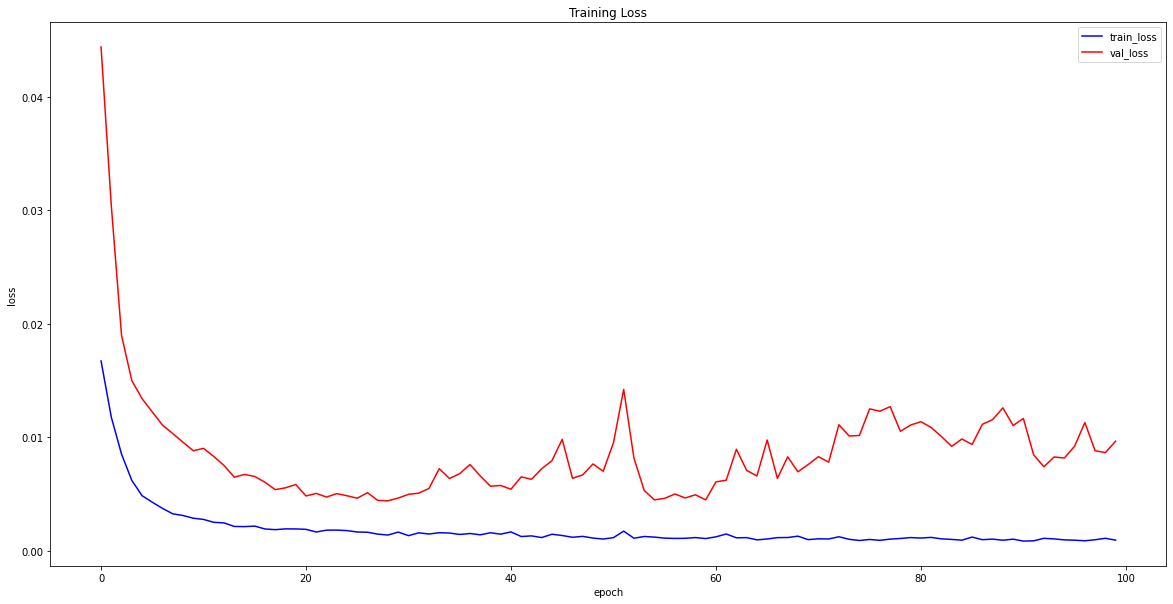

In [99]:
plt.figure(figsize=(20,10))
plt.plot(custom_hist.train_loss, color = 'blue', label = 'train_loss')
plt.plot(custom_hist.val_loss, color = 'red', label = 'val_loss')
plt.title('Training Loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [100]:
from keras.models import load_model
model = load_model('/content/best-model-cabbage.h5')

Train Data *평가*

In [101]:
model.evaluate(trainX, trainY, batch_size=a)

477/477 [==============================] - 2s 3ms/step - loss: 0.0016 - mae: 0.0317


[0.001632230938412249, 0.031731896102428436]

In [102]:
predicted_price_train = model.predict(trainX, batch_size=a, verbose=1) 

477/477 [==============================] - 2s 2ms/step


In [103]:
trainY_test = np.delete(trainY, np.s_[1:a], axis=1)
predicted_price_train_test = np.delete(predicted_price_train, np.s_[1:a], axis=1)

trainY_test = np.reshape(trainY_test, (1431, 1))
predicted_price_train_test = np.reshape(predicted_price_train_test, (1431, 1))
print(trainY_test.shape)
print(predicted_price_train_test.shape)

(1431, 1)
(1431, 1)


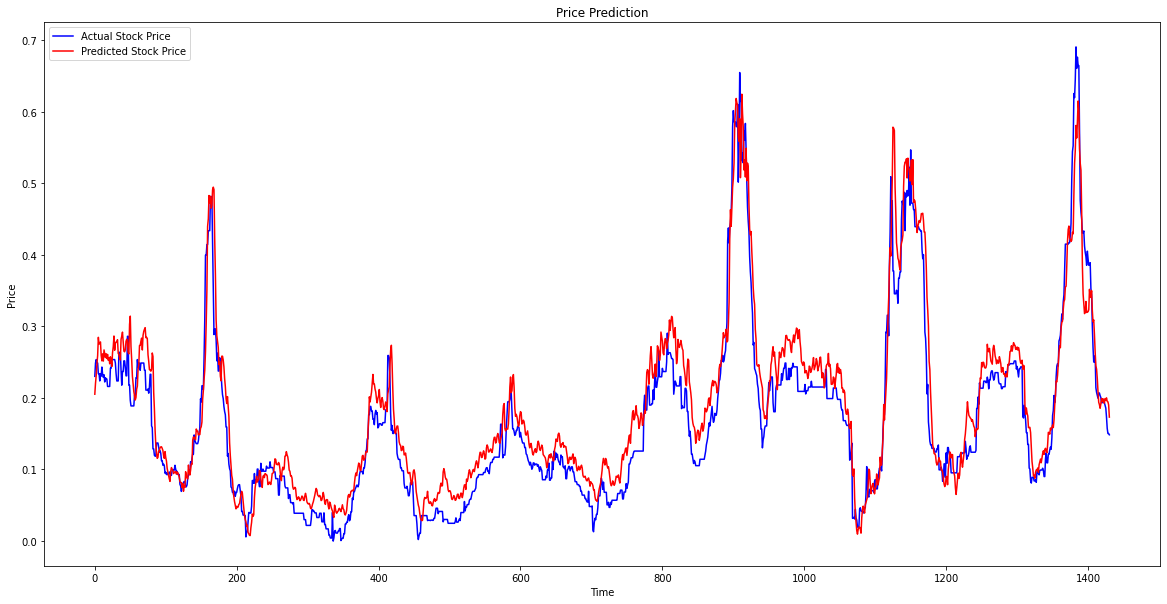

In [104]:
plt.figure(figsize=(20,10))
plt.plot(trainY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_train_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [105]:
predicted_price_train_test = np.reshape(predicted_price_train_test, (1431, ))
predicted_price_train_test = scaler_target.inverse_transform(predicted_price_train_test.reshape(-1,1))

print(predicted_price_train_test, predicted_price_train_test.shape)

trainY_test = scaler_target.inverse_transform(trainY_test.reshape(-1,1))

print(trainY_test, trainY_test.shape)

[[3845.9436]
 [4017.8406]
 [4140.581 ]
 ...
 [3727.0964]
 [3677.7346]
 [3488.1924]] (1431, 1)
[[4125.]
 [4333.]
 [4387.]
 ...
 [3232.]
 [3232.]
 [3212.]] (1431, 1)


In [106]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(trainY_test, predicted_price_train_test) 
np.sqrt(MSE)

451.6412603834761

In [107]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(trainY_test, predicted_price_train_test)

354.81101519506683

Val Date 평가


In [108]:
model.evaluate(validX, validY, batch_size=a)

159/159 [==============================] - 1s 3ms/step - loss: 0.0044 - mae: 0.0436


[0.004411904141306877, 0.04356023669242859]

In [109]:
predicted_price_valid = model.predict(validX, batch_size=a, verbose=1) 

159/159 [==============================] - 0s 3ms/step


(477, 1)
(477, 1)


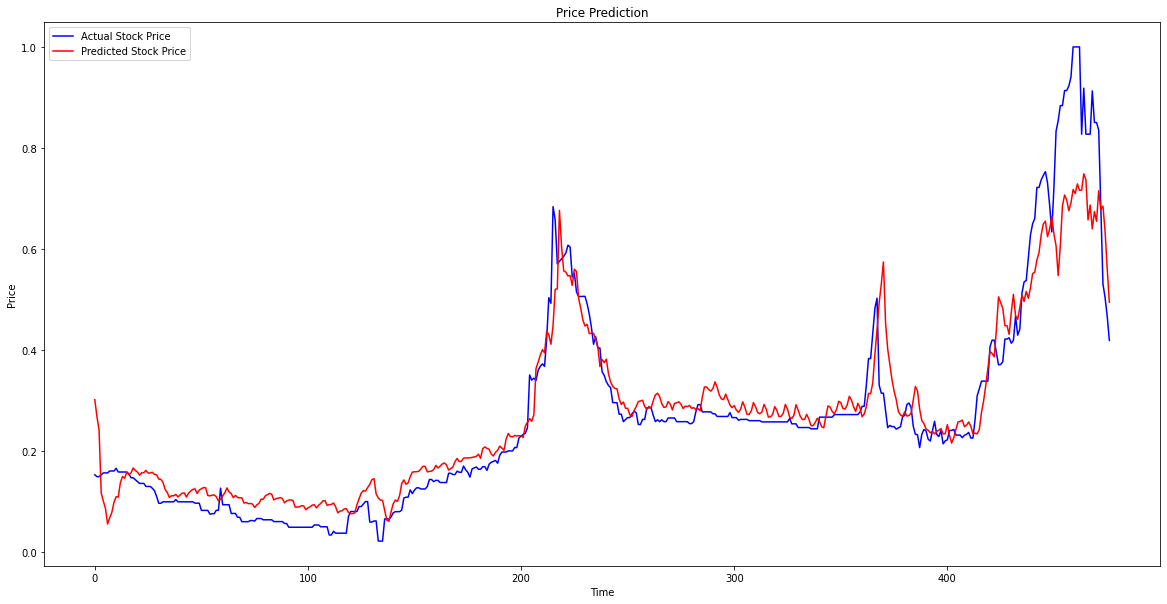

In [110]:
validY_test = np.delete(validY, np.s_[1:a], axis=1)
predicted_price_valid_test = np.delete(predicted_price_valid, np.s_[1:a], axis=1)

validY_test = np.reshape(validY_test, (477, 1))
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (477, 1))
print(validY_test.shape)
print(predicted_price_valid_test.shape)

plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [111]:
predicted_price_valid_test = np.reshape(predicted_price_valid_test, (477, ))
predicted_price_valid_test = scaler_target.inverse_transform(predicted_price_valid_test.reshape(-1,1))

print(predicted_price_valid_test, predicted_price_valid_test.shape)

validY_test = scaler_target.inverse_transform(validY_test.reshape(-1,1))

print(validY_test, validY_test.shape)

[[4918.7324]
 [4544.8496]
 [4250.273 ]
 [2858.4011]
 [2672.31  ]
 [2512.2664]
 [2165.1328]
 [2303.9265]
 [2424.0608]
 [2646.9106]
 [2770.7415]
 [2762.298 ]
 [3081.8083]
 [3218.2397]
 [3180.454 ]
 [3315.1348]
 [3260.4329]
 [3299.2969]
 [3407.4126]
 [3352.5334]
 [3318.3103]
 [3247.4185]
 [3302.487 ]
 [3303.61  ]
 [3352.736 ]
 [3293.6948]
 [3297.9006]
 [3310.3713]
 [3263.6055]
 [3255.9949]
 [3160.8472]
 [3154.0957]
 [3088.28  ]
 [2931.5515]
 [2864.0833]
 [2753.5103]
 [2792.5322]
 [2790.8552]
 [2822.067 ]
 [2765.2664]
 [2806.8057]
 [2849.9287]
 [2854.3542]
 [2762.6252]
 [2850.5208]
 [2896.3733]
 [2933.171 ]
 [2944.0437]
 [2843.0503]
 [2916.066 ]
 [2947.4587]
 [2973.8406]
 [2968.785 ]
 [2797.885 ]
 [2789.7163]
 [2802.5261]
 [2811.57  ]
 [2769.6877]
 [2678.2544]
 [2719.576 ]
 [2788.2844]
 [2856.758 ]
 [2966.0747]
 [2877.8108]
 [2838.321 ]
 [2749.8054]
 [2800.3923]
 [2753.3943]
 [2747.0554]
 [2745.1067]
 [2629.7678]
 [2644.438 ]
 [2616.6072]
 [2620.702 ]
 [2607.8936]
 [2531.1257]
 [2589.2163]

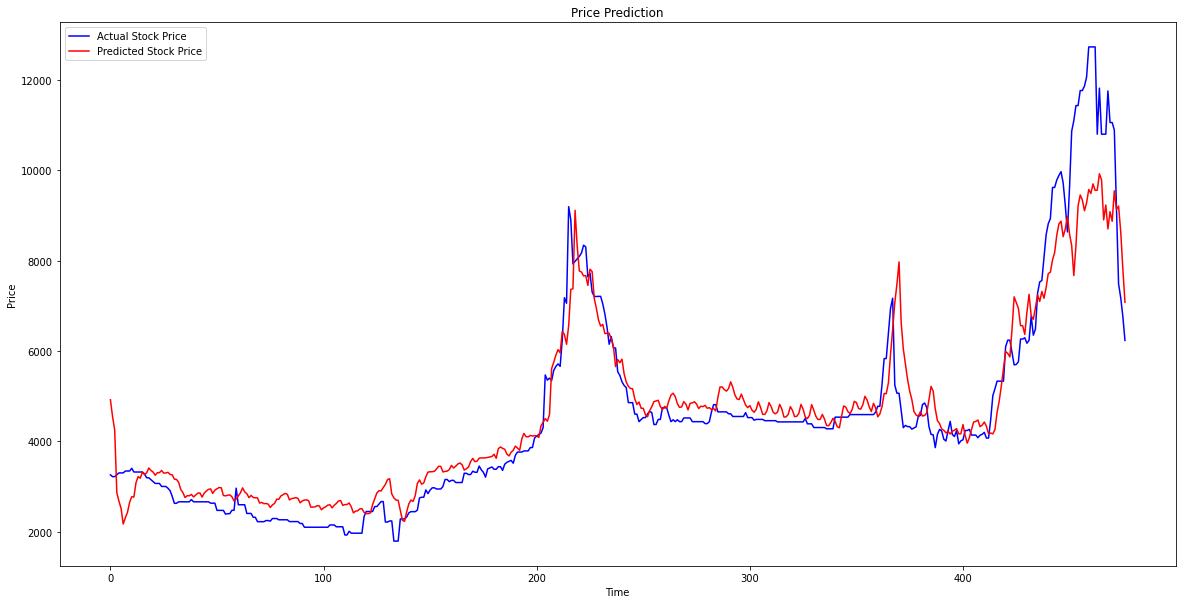

In [112]:
plt.figure(figsize=(20,10))
plt.plot(validY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_valid_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [113]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(validY_test, predicted_price_valid_test) 
np.sqrt(MSE)

756.1201601605264

In [114]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(validY_test, predicted_price_valid_test)

502.5541377997248

Test Data 평가

In [115]:
model.evaluate(testX, testY, batch_size=a)

159/159 [==============================] - 1s 3ms/step - loss: 0.0067 - mae: 0.0637


[0.006689255591481924, 0.06366720050573349]

In [116]:
predicted_price_test = model.predict(testX, batch_size=a, verbose=1)

159/159 [==============================] - 0s 3ms/step


(477, 1)
(477, 1)


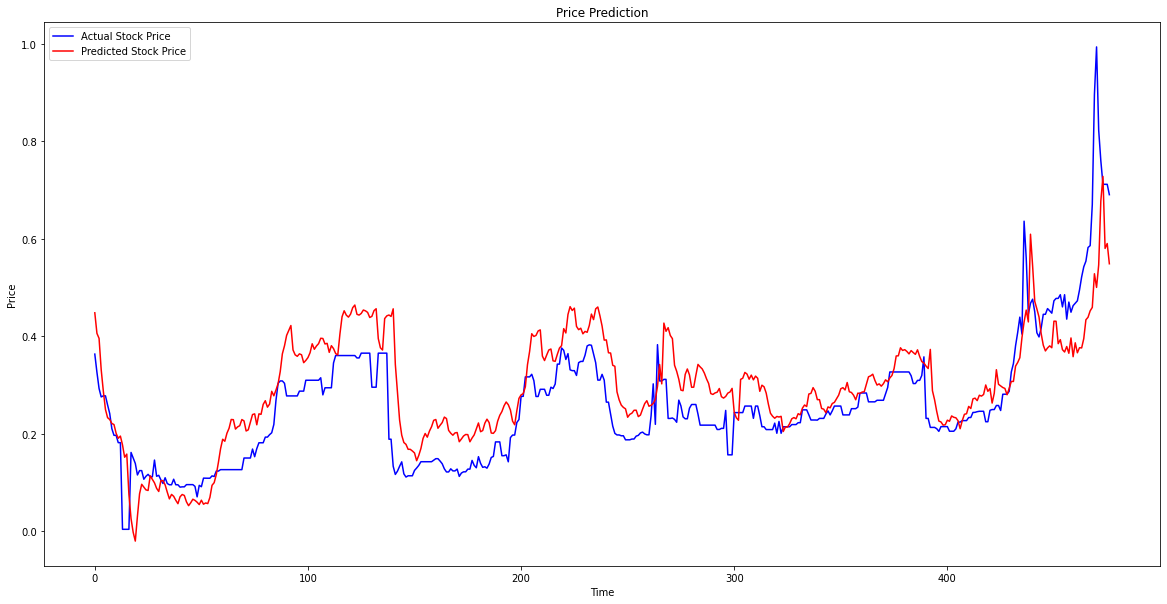

In [117]:
testY_test = np.delete(testY, np.s_[1:a], axis=1)
predicted_price_test_test = np.delete(predicted_price_test, np.s_[1:a], axis=1)

testY_test = np.reshape(testY_test, (477, 1))
predicted_price_test_test = np.reshape(predicted_price_test_test, (477, 1))
print(testY_test.shape)
print(predicted_price_test_test.shape)

plt.figure(figsize=(20,10))
plt.plot(testY_test, color = 'blue', label = 'Actual Stock Price')
plt.plot(predicted_price_test_test, color = 'red', label = 'Predicted Stock Price')
plt.title('Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()

In [118]:
predicted_price_test_test = np.reshape(predicted_price_test_test, (477, ))
predicted_price_test_test = scaler_target.inverse_transform(predicted_price_test_test.reshape(-1,1))

print(predicted_price_test_test, predicted_price_test_test.shape)

testY_test = scaler_target.inverse_transform(testY_test.reshape(-1,1))

print(testY_test, testY_test.shape)

[[6561.6323]
 [6089.7026]
 [5974.0044]
 [5255.153 ]
 [4762.6597]
 [4342.4717]
 [4152.943 ]
 [4111.924 ]
 [4020.178 ]
 [3995.28  ]
 [3795.1062]
 [3679.2976]
 [3731.6016]
 [3526.5078]
 [3245.076 ]
 [3316.984 ]
 [2391.966 ]
 [1838.3298]
 [1521.8293]
 [1319.4851]
 [1888.5612]
 [2405.7966]
 [2623.7114]
 [2557.759 ]
 [2495.2327]
 [2481.9004]
 [2818.764 ]
 [2737.8323]
 [2656.7603]
 [2530.547 ]
 [2458.7144]
 [2708.5823]
 [2707.8418]
 [2609.84  ]
 [2442.3198]
 [2288.769 ]
 [2391.1326]
 [2348.3098]
 [2256.789 ]
 [2178.4941]
 [2335.815 ]
 [2389.4731]
 [2367.3704]
 [2221.165 ]
 [2132.9102]
 [2199.3132]
 [2280.8596]
 [2254.4424]
 [2212.2925]
 [2157.855 ]
 [2258.147 ]
 [2166.7793]
 [2194.994 ]
 [2180.6821]
 [2322.3906]
 [2600.5293]
 [2660.5488]
 [2846.4695]
 [3128.8276]
 [3438.7156]
 [3658.3894]
 [3611.4055]
 [3796.592 ]
 [3910.9834]
 [4111.892 ]
 [4107.5913]
 [3891.184 ]
 [3941.923 ]
 [3969.1936]
 [4110.7617]
 [4079.4863]
 [3847.5708]
 [3873.9316]
 [4048.3826]
 [4225.36  ]
 [4240.9883]
 [3989.807 ]

In [119]:
from sklearn.metrics import mean_squared_error 
MSE = mean_squared_error(testY_test, predicted_price_test_test) 
np.sqrt(MSE)

913.900197635277

In [120]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(testY_test, predicted_price_test_test)

711.8791926162048

예측방법

In [121]:
minX1 = np.array(dataX[0:3])
minX2 = np.array(dataX[0:4])
minX3 = np.array(dataX[0:2385])
minX4 = np.array(dataX[0:train_size])

In [122]:
predicted_price_min1 = model.predict(minX1, batch_size=a, verbose=1)
predicted_price_min2 = model.predict(minX2, batch_size=a, verbose=1) 
predicted_price_min3 = model.predict(minX3, batch_size=a, verbose=1)
predicted_price_min4 = model.predict(minX4, batch_size=a, verbose=1) 

477/477 [==============================] - 1s 3ms/step


In [124]:
predicted_price_min1[0]

array([[0.31395215],
       [0.26088464],
       [0.20850791]], dtype=float32)

In [125]:
predicted_price_min2[0]

array([[0.15652105],
       [0.1484292 ],
       [0.14172032]], dtype=float32)

In [126]:
predicted_price_min3[0]

array([[0.18490694],
       [0.20685044],
       [0.2093525 ]], dtype=float32)

In [127]:
scaler_target.inverse_transform(predicted_price_min4[0].reshape(-1,1))

array([[5062.299],
       [4468.951],
       [3883.327]], dtype=float32)